<a href="https://colab.research.google.com/github/ErdalNayir/Tensorflow_Keras_Functional_Api_Model/blob/main/SeminerProje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erdal002","key":"ce3786dedce8ddcf2dd1ab66165d1ee6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 90% 57.0M/63.2M [00:00<00:00, 144MB/s]
100% 63.2M/63.2M [00:00<00:00, 134MB/s]


In [8]:
!unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [54]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,concatenate
from keras.callbacks import EarlyStopping

In [17]:
resimVeriWithMeta=pd.read_csv('age_gender.csv')

In [19]:
resimVeriWithMeta.head(5)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [20]:
resimVeriWithMeta.shape # 23705 tane resim verisi bulunmakta

(23705, 5)

In [21]:
resimVeri=np.zeros(shape=(23705,2304))

for i in range(len(resimVeriWithMeta.pixels)):
    resimVeriWithMeta.pixels[i]=np.array(resimVeriWithMeta.pixels[i].split(),dtype='float32')
    resimVeri[i]=resimVeriWithMeta.pixels[i]

<ipython-input-21-bc39c1ae160a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resimVeriWithMeta.pixels[i]=np.array(resimVeriWithMeta.pixels[i].split(),dtype='float32')


In [23]:
resimVeri.shape # 48*48 = 2304 demekki resim boyutları 48*48 

(23705, 2304)

In [24]:
resimVeriShaped=resimVeri.reshape(-1,48,48,1)

In [26]:
resimVeriShaped.shape # pixel verileri resme dönüştürüldü sondaki bir resim boyutunu belirtir

(23705, 48, 48, 1)

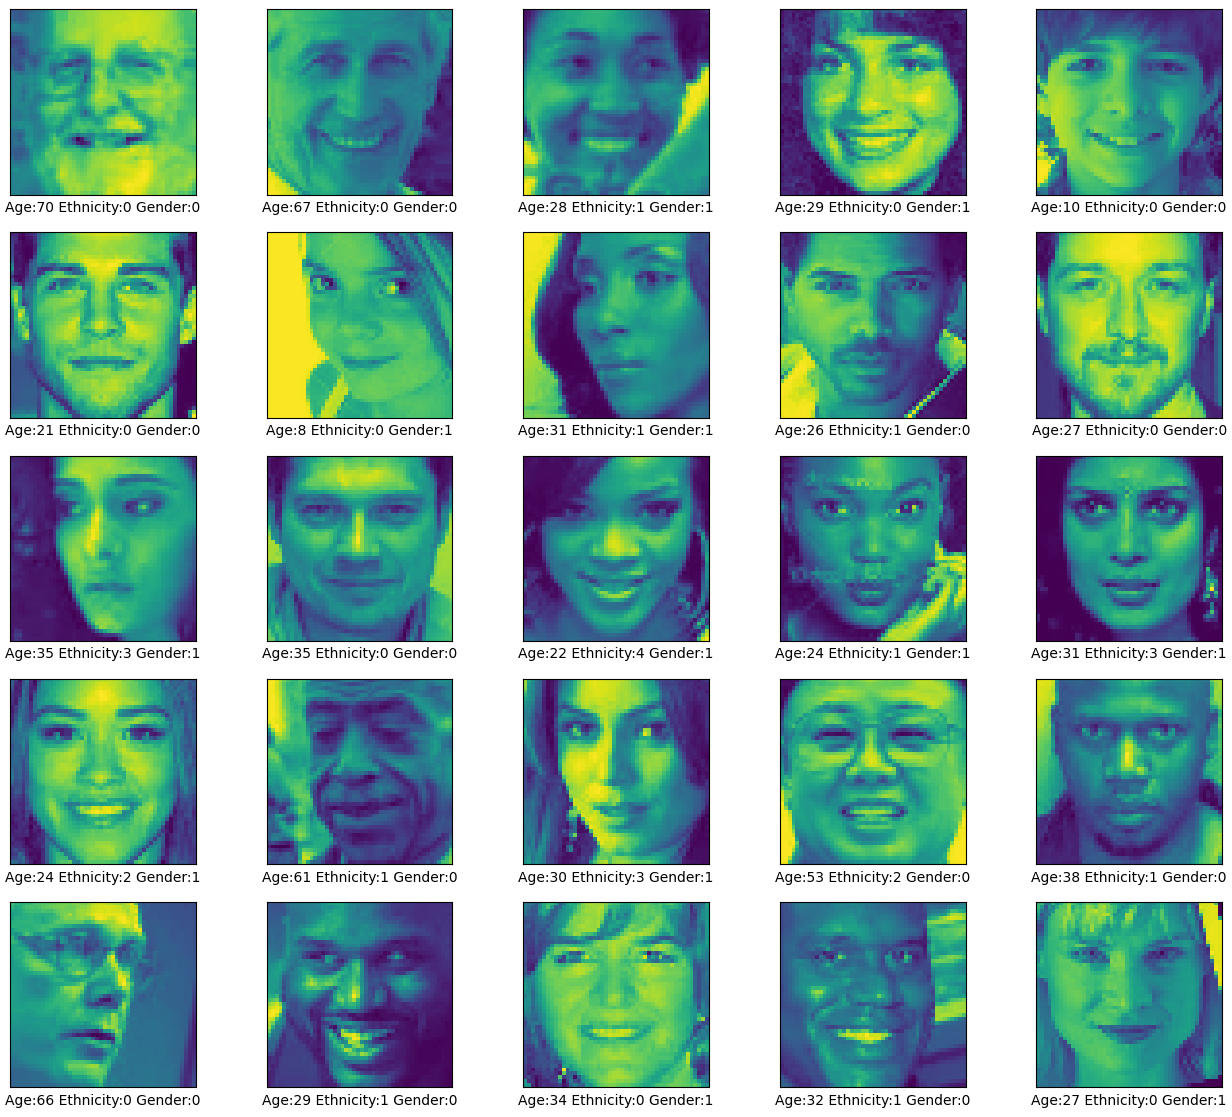

In [88]:
#print random images

index=np.random.randint(0,23704,25)


plt.figure(figsize=(16,14))

for i in range(len(index)):
    plt.subplot(5,5,(i%25)+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(resimVeriShaped[index[i]].reshape(48,48))
    plt.xlabel(
        "Age:"+str(resimVeriWithMeta['age'].iloc[index[i]])+
        " Ethnicity:"+str(resimVeriWithMeta['ethnicity'].iloc[index[i]])+
        " Gender:"+str(resimVeriWithMeta['gender'].iloc[index[i]])
    )
    
plt.show()

In [34]:
resimVeriWithMeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [35]:
resimVeriWithMeta.gender=resimVeriWithMeta.gender.astype('object')
resimVeriWithMeta.ethnicity=resimVeriWithMeta.ethnicity.astype('object')

In [38]:
resimVeriWithMeta.info() # cinsiyet ve etnik objeye çevrildi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  object
 2   gender     23705 non-null  object
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(1), object(4)
memory usage: 926.1+ KB


In [39]:
from keras.utils import to_categorical

Y_age=np.array([resimVeriWithMeta.age]).T
Y_Gender=np.array(to_categorical(resimVeriWithMeta.gender))
Y_Ethnic=np.array(to_categorical(resimVeriWithMeta.ethnicity))

In [45]:
Y_Ethnic # veriler kodlandı

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Model Oluşturma

In [49]:
#GİRİŞ KATMANLARINI OLUŞTRUMA

# Giriş: Cinsiyet verisi
gender_input = keras.Input(shape=(2,))

# Giriş: Siyah beyaz resim
image_input = keras.Input(shape=(48, 48, 1))

In [50]:
# Resim işleme katmanları

x = Conv2D(32, kernel_size=(3, 3), activation="relu",padding="same")(image_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)


In [52]:
# Cinsiyet ve resim verilerini birleştirme
combined = concatenate([x, gender_input])

In [53]:
# Ortak katmanlar ve çıkış katmanı
x = Dense(64, activation="relu")(combined)
output = Dense(5, activation="softmax")(x)  # 5 sınıf için softmax kullanıyoruz

In [55]:
model = Model(inputs=[image_input, gender_input], outputs=output)

In [57]:
model.summary() # model özeti

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_6[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

In [69]:
batch_size=32
epochs=20

from keras.optimizers import Adam

# EarlyStopping callback'i oluşturma
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

opt=Adam(learning_rate=0.001)

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
resimVeriShaped.shape 

(23705, 48, 48, 1)

In [61]:
Y_Gender.shape

(23705, 2)

In [62]:
Y_Ethnic.shape

(23705, 5)

In [63]:
from sklearn.model_selection import train_test_split



# Verileri eğitim ve test olarak bölmek
x_train_img, x_test_img, x_train_gender, x_test_gender, y_train, y_test = train_test_split(
    resimVeriShaped, Y_Gender, Y_Ethnic, test_size=0.2, random_state=42
)

In [64]:
# Eğitim ve test veri setlerinin boyutlarını kontrol etmek
print("Eğitim veri seti (resim):", x_train_img.shape)
print("Test veri seti (resim):", x_test_img.shape)
print("Eğitim veri seti (cinsiyet):", x_train_gender.shape)
print("Test veri seti (cinsiyet):", x_test_gender.shape)
print("Eğitim veri seti (etnik):", y_train.shape)
print("Test veri seti (etnik):", y_test.shape)

Eğitim veri seti (resim): (18964, 48, 48, 1)
Test veri seti (resim): (4741, 48, 48, 1)
Eğitim veri seti (cinsiyet): (18964, 2)
Test veri seti (cinsiyet): (4741, 2)
Eğitim veri seti (etnik): (18964, 5)
Test veri seti (etnik): (4741, 5)


In [70]:
history = model.fit([x_train_img, x_train_gender], y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=([x_test_img,x_test_gender], y_test))

Epoch 1/20
593/593 [==============================] - 336s 565ms/step - loss: 0.8800 - accuracy: 0.6947 - val_loss: 0.7630 - val_accuracy: 0.7351
Epoch 2/20
593/593 [==============================] - 334s 563ms/step - loss: 0.6650 - accuracy: 0.7683 - val_loss: 0.7287 - val_accuracy: 0.7473
Epoch 3/20
593/593 [==============================] - 332s 559ms/step - loss: 0.5930 - accuracy: 0.7936 - val_loss: 0.6694 - val_accuracy: 0.7673
Epoch 4/20
593/593 [==============================] - 333s 562ms/step - loss: 0.5460 - accuracy: 0.8093 - val_loss: 0.6104 - val_accuracy: 0.7912
Epoch 5/20
593/593 [==============================] - 324s 547ms/step - loss: 0.4986 - accuracy: 0.8287 - val_loss: 0.6466 - val_accuracy: 0.7846
Epoch 6/20
593/593 [==============================] - 324s 546ms/step - loss: 0.4634 - accuracy: 0.8413 - val_loss: 0.7002 - val_accuracy: 0.7655
Epoch 7/20
593/593 [==============================] - 320s 540ms/step - loss: 0.4226 - accuracy: 0.8524 - val_loss: 0.6603 -

In [73]:
# Model eğitimi kötüye gittiğinden early stopping ile model durduruldu

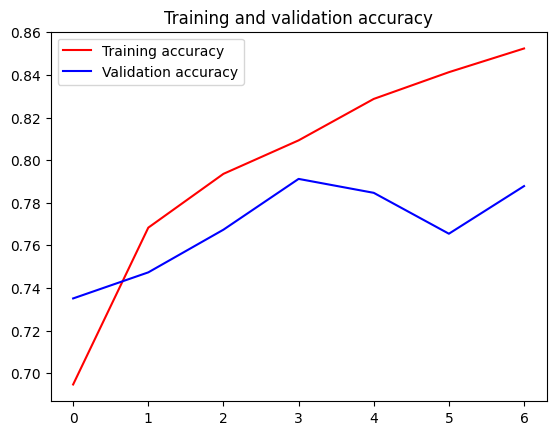

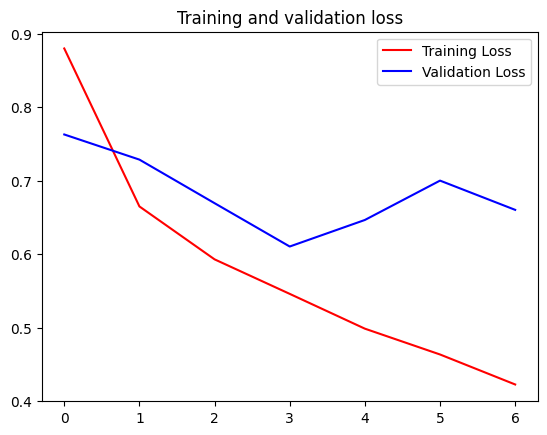

In [72]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:

# Modeli evaluate etme
loss, accuracy = model.evaluate([x_test_img, x_test_gender], y_test)

# Elde edilen metrikleri yazdırma
print("Test verisi üzerinde kayıp (loss):", loss)
print("Test verisi üzerinde doğruluk (accuracy):", accuracy)

149/149 [==============================] - 20s 130ms/step - loss: 0.6104 - accuracy: 0.7912
Test verisi üzerinde kayıp (loss): 0.6104241013526917
Test verisi üzerinde doğruluk (accuracy): 0.7911832928657532


In [75]:
# Test verileri üzerinde tahmin yapma
predictions = model.predict([x_test_img, x_test_gender])

# Tahmin sonuçlarını değerlendirme veya kullanma
# Burada örnek olarak ilk örneğin tahmin sonucunu yazdırıyoruz
print("Tahmin sonucu:", predictions[0])

149/149 [==============================] - 19s 129ms/step
Tahmin sonucu: [0.11002613 0.08564109 0.07922774 0.25705215 0.4680528 ]


In [76]:
# Tahmin sonuçlarını sınıfa dönüştürme
predicted_classes = predictions.argmax(axis=1)

# İlk örneğin tahmin edilen sınıfını yazdırma
print("Tahmin edilen sınıf:", predicted_classes[0])

Tahmin edilen sınıf: 4


According to pictures of people(I dont have much idea what this numbers refer to which ethnics)

0==White
1==Black
2==Asian
3==İndian
4==Latin

In [79]:
predicted_names =[]

for i in range(len(predicted_classes)):
  if predicted_classes[i] == 0:
    predicted_names.append("white")
  elif predicted_classes[i] == 1:
    predicted_names.append("black")
  elif predicted_classes[i] == 2:
    predicted_names.append("asian")
  elif predicted_classes[i] == 1:
    predicted_names.append("black")
  elif predicted_classes[i] == 3:
    predicted_names.append("indian")
  elif predicted_classes[i] == 4:
    predicted_names.append("latin")

In [80]:
len(predicted_names)

4741

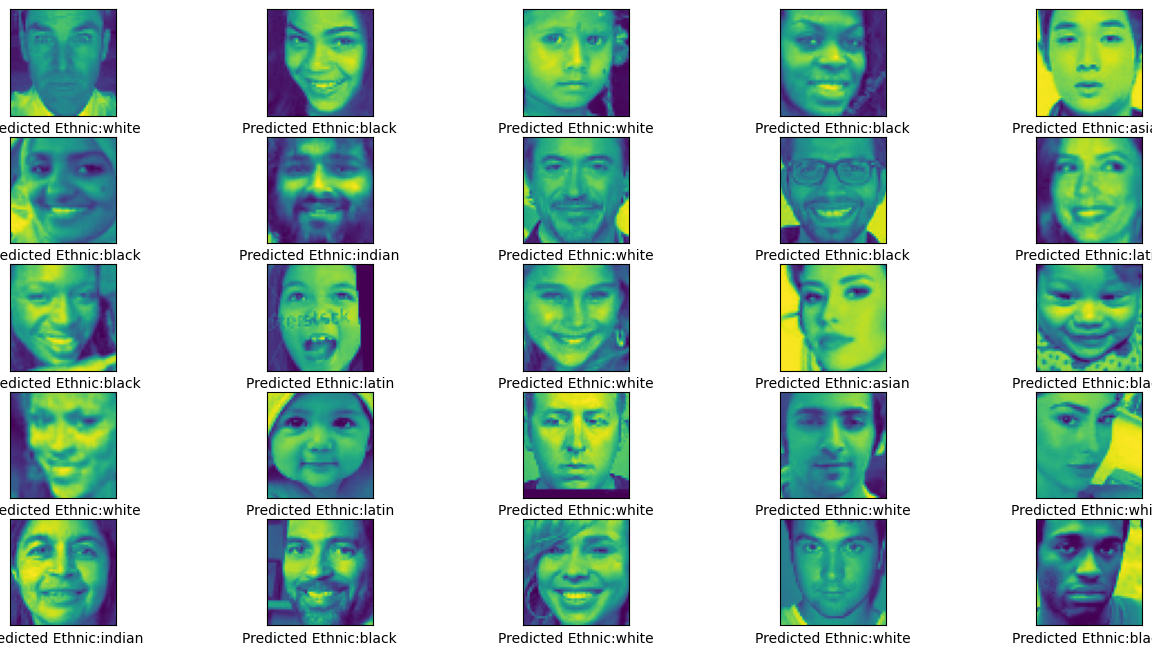

In [83]:
index=np.random.randint(0,4741,25) # predicted label and their images

plt.figure(figsize=(16,8))

for i in range(len(index)):
    plt.subplot(5,5,(i%25)+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_img[index[i]].reshape(48,48))
    plt.xlabel("Predicted Ethnic:"+str(predicted_names[index[i]])
    )
    
plt.show()